In [1]:
#### IAU Project Phase 3 - Machine Learning
#### Andrej Horváth / Adam Partl
#### Share of work : 50% / 50%

In [53]:
import pandas as pd
import matplotlib.pyplot  as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

### 4.1 A) EDA

In [4]:
file_path = 'data/NFLX.csv'
netflix_data = pd.read_csv(file_path)

In [6]:
netflix_data.head(), netflix_data.info(), netflix_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.6+ KB


(         Date      Open      High       Low     Close  Adj Close     Volume
 0  2002-05-23  1.156429  1.242857  1.145714  1.196429   1.196429  104790000
 1  2002-05-24  1.214286  1.225000  1.197143  1.210000   1.210000   11104800
 2  2002-05-28  1.213571  1.232143  1.157143  1.157143   1.157143    6609400
 3  2002-05-29  1.164286  1.164286  1.085714  1.103571   1.103571    6757800
 4  2002-05-30  1.107857  1.107857  1.071429  1.071429   1.071429   10154200,
 None,
             Date        Open        High         Low       Close   Adj Close  \
 4576  2020-07-28  496.019989  497.790009  487.760010  488.510010  488.510010   
 4577  2020-07-29  492.250000  494.920013  484.130005  484.480011  484.480011   
 4578  2020-07-30  480.709991  488.350006  477.510010  485.799988  485.799988   
 4579  2020-07-31  488.290009  494.799988  484.500000  488.880005  488.880005   
 4580  2020-08-03  490.859985  503.089996  490.230011  498.619995  498.619995   
 
        Volume  
 4576  5986700  
 4577  6

We can see from the output, that the dataset contains 7 columns.
The date column has object type, we need to change that to datetime for proper time-series analysis.
Volume is an integer representing the trading volume.
The rest are floats representing stock prices. (Open - start of the day, High/Low - highest/lowest stock price of the day, Close - closing price of the day, Adj Close - close adjusted for splits(more accurate for forecasting).)
The records range from 23/5/2002 - 3/8/2020
Additionally an important thing is that the data do not contain missing values.
We continue by changing the type of the date column and set it as the index

In [21]:
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'])
netflix_data.set_index('Date', inplace=True)

In [12]:
netflix_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


From the description, we get to see the mins, maxes, means and so on, which give us an ide of the distribution

We can continue by plotting the closing value of the stocks in time to see how it progressed

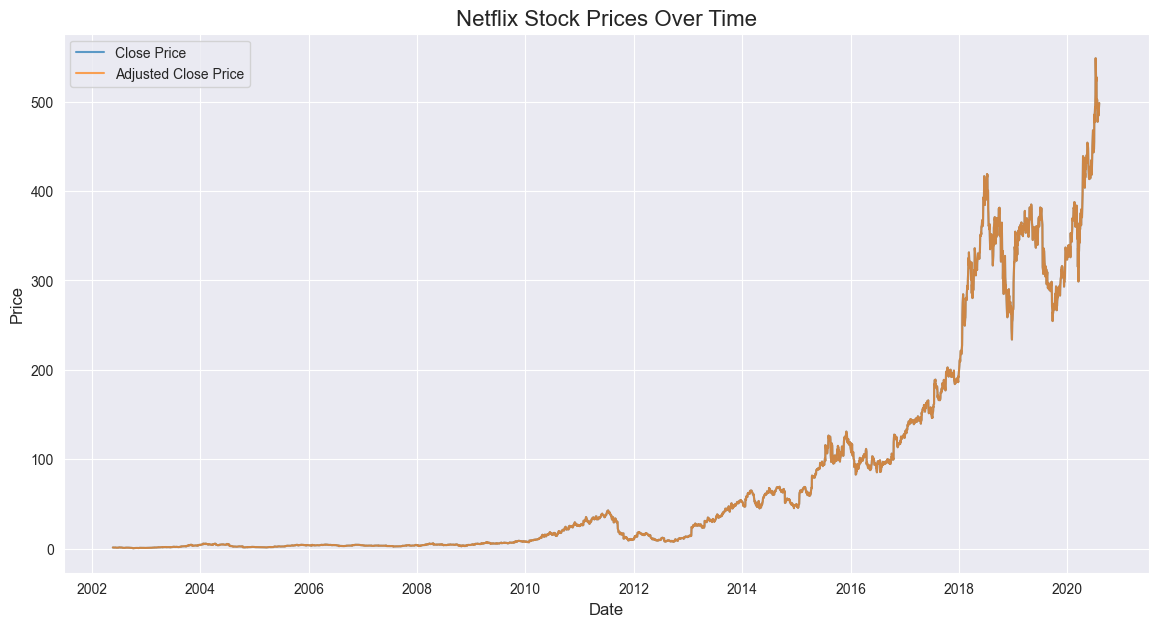

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(netflix_data['Close'], label='Close Price', alpha=0.7)
plt.plot(netflix_data['Adj Close'], label='Adjusted Close Price', alpha=0.7)
plt.title('Netflix Stock Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

What can we see from the graph:
  - Steady but insignificant growth in 2002-2010
  - Significant rise in stock price after 2016
  - Big rise around 2020 which can reflect COVID-19

Next we can plot moving averages, which can give us insight into short term trends and take long term fluctuations out of the picture
Other than that we will plot a daily percentage change, to see the volatility of the stock price

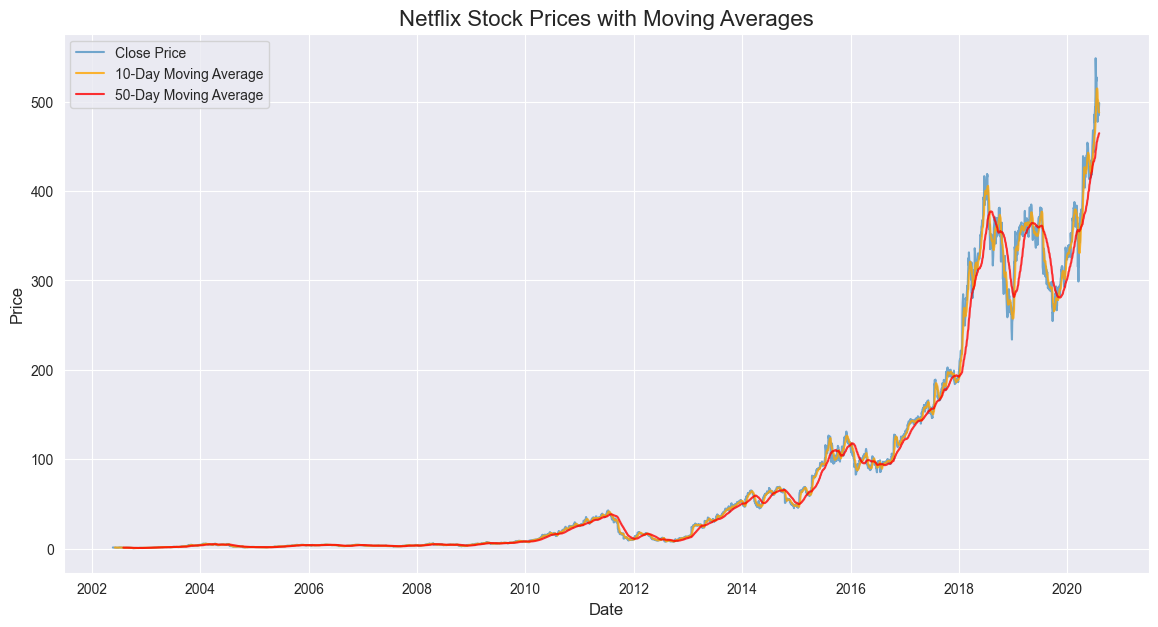

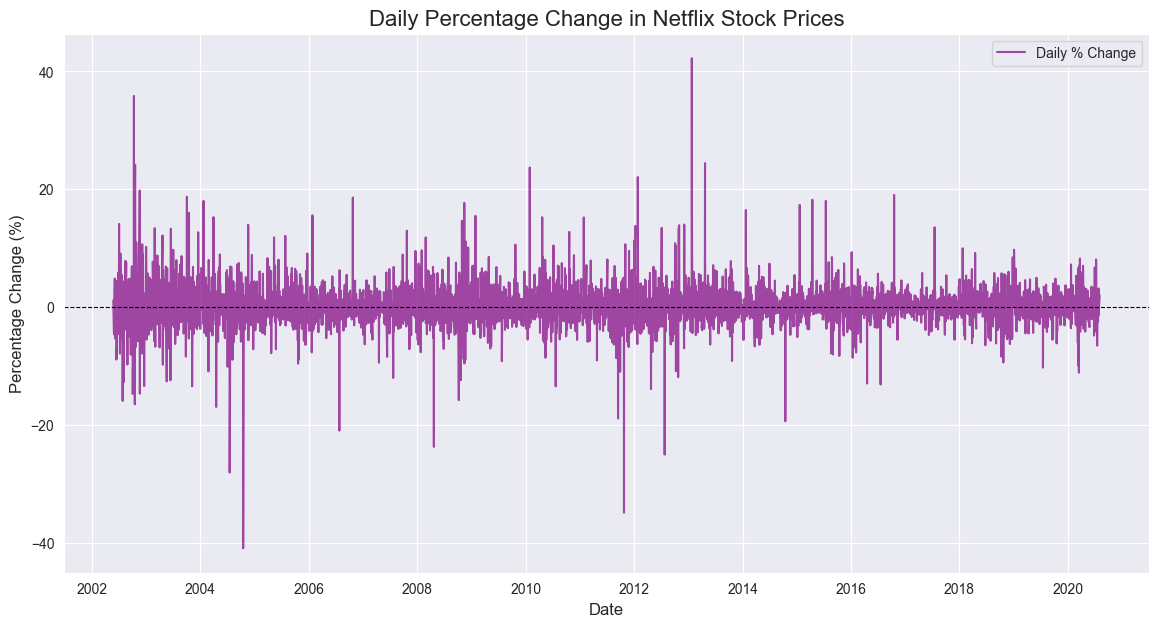

In [23]:
netflix_data['MA_10'] = netflix_data['Close'].rolling(window=10).mean()
netflix_data['MA_50'] = netflix_data['Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(netflix_data['Close'], label='Close Price', alpha=0.6)
plt.plot(netflix_data['MA_10'], label='10-Day Moving Average', color='orange', alpha=0.8)
plt.plot(netflix_data['MA_50'], label='50-Day Moving Average', color='red', alpha=0.8)
plt.title('Netflix Stock Prices with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

netflix_data['Daily_Change_%'] = netflix_data['Close'].pct_change() * 100

plt.figure(figsize=(14, 7))
plt.plot(netflix_data['Daily_Change_%'], label='Daily % Change', color='purple', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Daily Percentage Change in Netflix Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

From the 10-day moving average we can see short term trends, and from the 50-day-long term trends
This helps us understand the development of the stock price
When the two get closer, it suggests reduced volatility of the stock price 

From the daily percentage change graph, we can observe that the large spikes indicate high volatility
After a significant spike, the percentage change typically returns to normal
So in conclusion, the volatile spots are less likely to be accurate during a prediction.

As a next step we perform seasonal decomposition

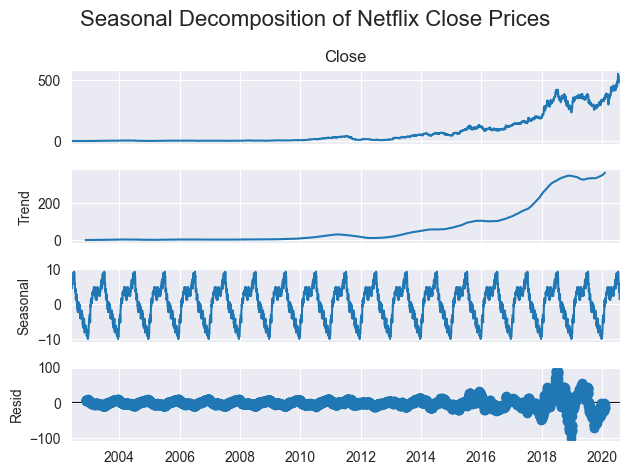

In [25]:
decomposition = seasonal_decompose(netflix_data['Close'], model='additive', period=252)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Netflix Close Prices', fontsize=16)
plt.tight_layout()
plt.show()

What can be observed from the graphs:
- Trend graph smoothed out short term fluctuations, showing true direction of the price
- Seasonal graph shows that the stock price follows a consistent annual cycle, indicating the price follows a pattern
- Residual shows random fluctuations, indicating highly volatile behavior 2018-2020

Now we will continue with a correlation matrix to analyze correlations

In [26]:
correlation_matrix = netflix_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
print(correlation_matrix)

               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999841  0.999830  0.999654   0.999654 -0.193770
High       0.999841  1.000000  0.999783  0.999840   0.999840 -0.192107
Low        0.999830  0.999783  1.000000  0.999834   0.999834 -0.195478
Close      0.999654  0.999840  0.999834  1.000000   1.000000 -0.193671
Adj Close  0.999654  0.999840  0.999834  1.000000   1.000000 -0.193671
Volume    -0.193770 -0.192107 -0.195478 -0.193671  -0.193671  1.000000


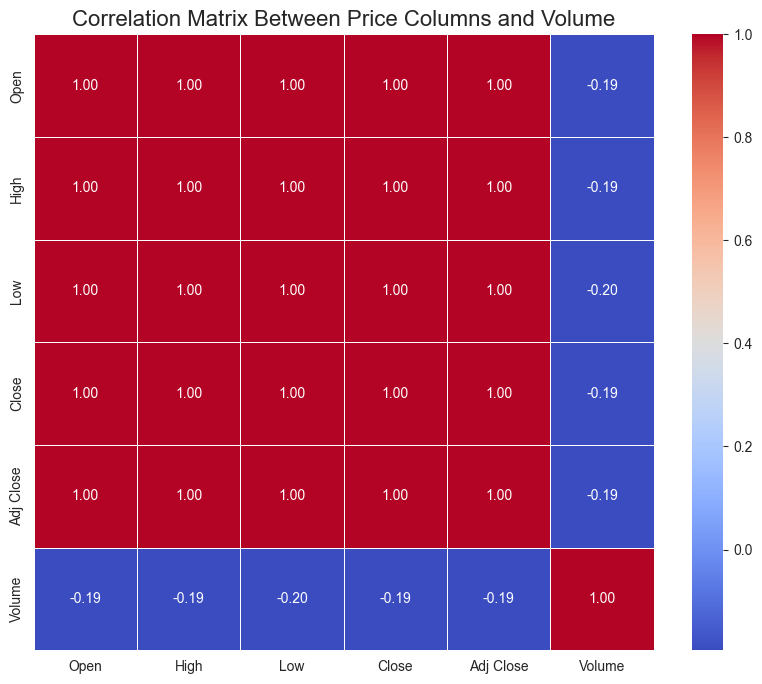

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Between Price Columns and Volume', fontsize=16)
plt.show()

Based on the matrix, we can see that the prices move together consistently
Other than that, it shows slight negative correlation between volume and price metrics, indicating that the volume is not necessarily linked to price increases.

We can further identify relationships between features by using a pair plot

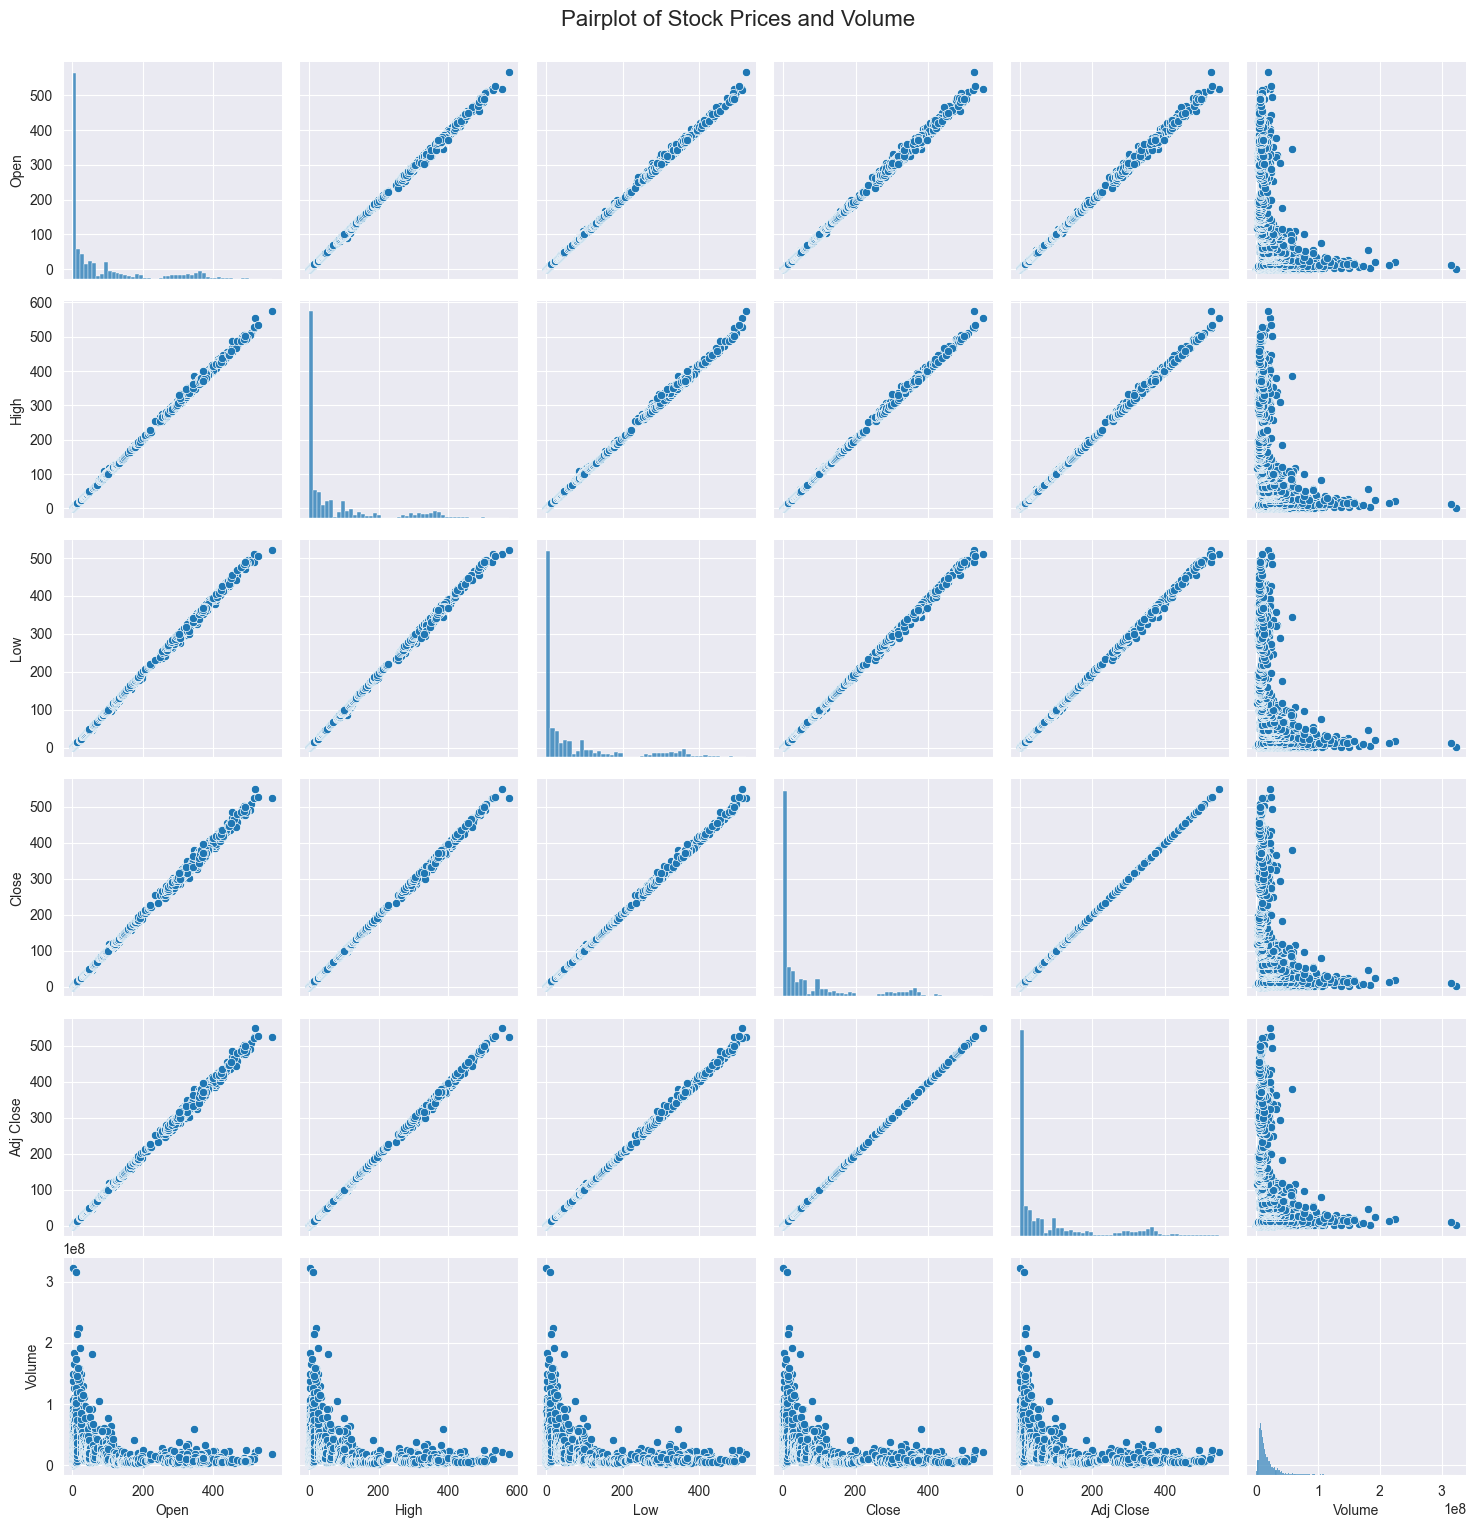

In [31]:
selected_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

sns.pairplot(netflix_data[selected_columns], height=2.5)
plt.suptitle('Pairplot of Stock Prices and Volume', fontsize=16, y=1.02)
plt.show()

Based on the pair plot we can see that the prices move together consistently, same as inside the correlation matrix.
Furthermore, we can observe higher volume with lower stock price, indicating that more stocks are being sold when their price is lower.

Next up, we can create a box plot, to see if we have any significant outliers

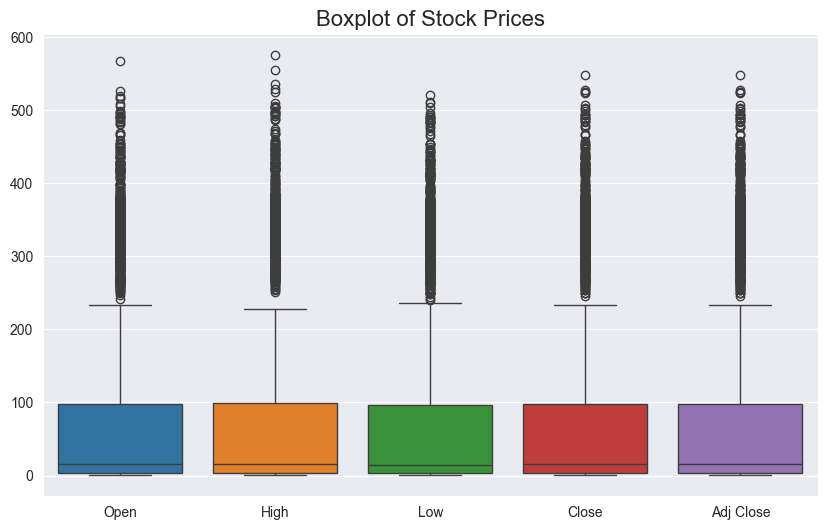

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=netflix_data[['Open', 'High', 'Low', 'Close', 'Adj Close']])
plt.title('Boxplot of Stock Prices', fontsize=16)
plt.show()

From the plot, we can observe that there are no significant outliers, only a few.

Now we can proceed with a Histogram to better understand the distribution

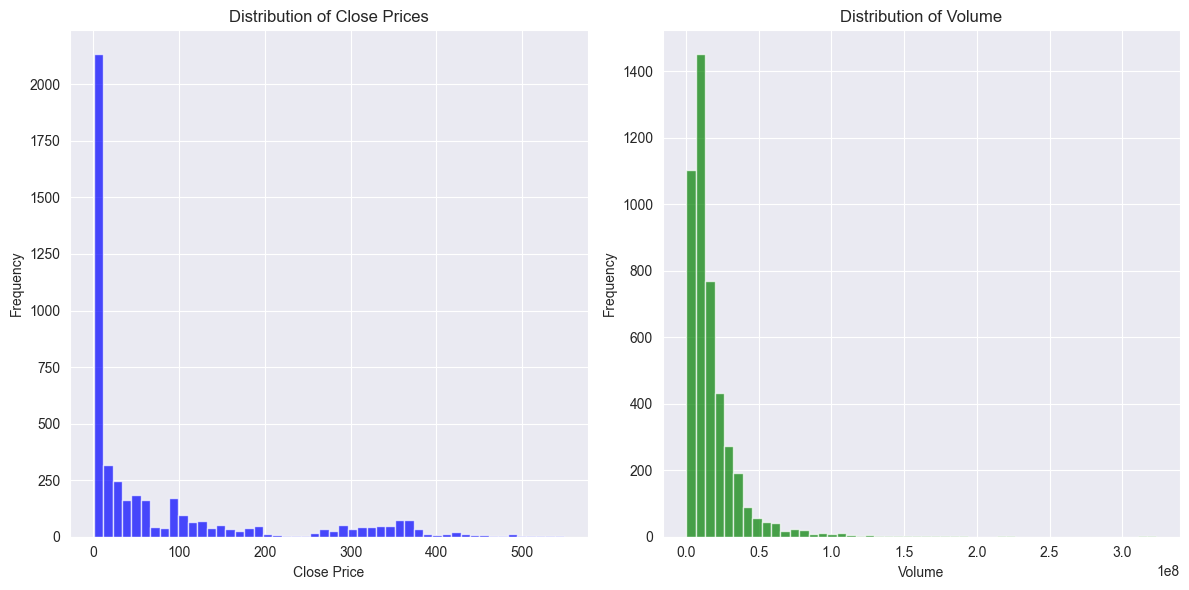

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(netflix_data['Close'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(netflix_data['Volume'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From these plots, it is noticeable that the most prices are between the 0-100 mark, which could be observed from the prices over time graph. The volume tends to be in the lowe portion as well (lower portion means up to 100 000 000), with the higher ones being above 300 000 000.

### 4.1 B)
Since we are working with a time-series forecasting task, RNN might be a suitable choice 
Based on this article https://www.sciencedirect.com/science/article/pii/S1877050922005865 We assume that for the time-series forcasting, it is going to be the best to use a deep learning model based on LSTM. Also, the article suggests that the adjustment closing price is the best one to use for the prediction, so we will focus on that one.

### Preprocessing
So we will continue with normalizing the Adj close value using minmax scaler

In [42]:
netflix_data = netflix_data.drop(['MA_10', 'MA_50', 'Daily_Change_%'], axis=1)
adj_close = netflix_data[['Adj Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
adj_close_scaled = scaler.fit_transform(adj_close)

netflix_data['Adj Close Scaled'] = adj_close_scaled

netflix_data.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close Scaled
Date,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,0.001502
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,0.001527
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,0.001430
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,0.001333
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,0.001274


In [40]:
sequence_length = 60

# Prepare the data
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])  # Input sequence
        targets.append(data[i, 0]) 
    return np.array(sequences), np.array(targets)

# Create sequences and targets
sequences, targets = create_sequences(adj_close_scaled, sequence_length)

# Split the data (80% train, 20% test)
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Reshape the data to the format expected by LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3616, 60, 1), (905, 60, 1), (3616,), (905,))

### Modelling

In [48]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

C:\Users\partl\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0011
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6843e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4197e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3939e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1946e-05
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3052e-05
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9549e-05
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6795e-05
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9042e-05
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7056e-05


In [50]:
predictions = model.predict(X_test)

predictions_inverse = scaler.inverse_transform(predictions)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


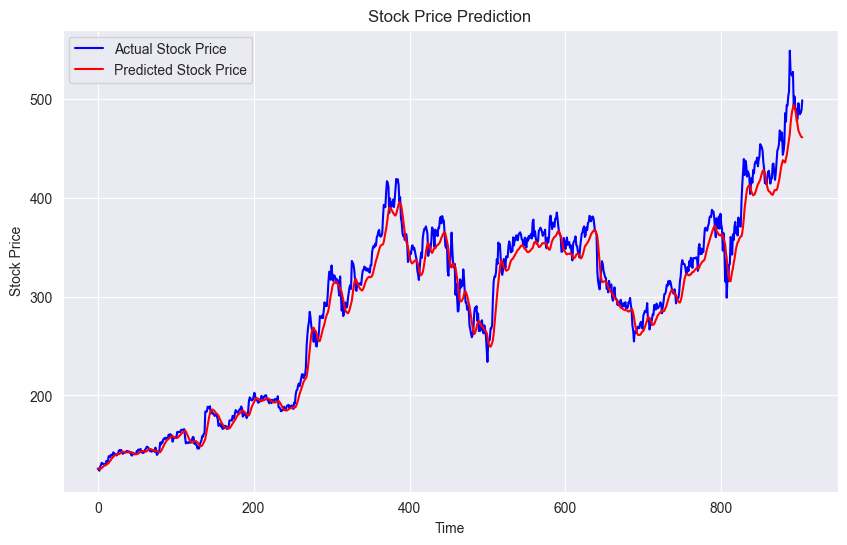

In [51]:
plt.figure(figsize=(10,6))
plt.plot(y_test_inverse, color='blue', label='Actual Stock Price')
plt.plot(predictions_inverse, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [54]:
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 16.0688980123313
